# Visualizing Bayesian Optimization 

This notebook contains both a one- and a two-dimensional example of Bayesian Optimization using a Gaussian Process as a surrogate aswell as the Upper Confidence Bound as an acquisition-function. Throughout this notebook, there are several sections that are marked as ###Settings### where you can change variables to test different settings. Further explanations are right next to each variable as an orientation.

Have fun!

In [9]:
import math
import numpy as np
import random
from matplotlib import pyplot as plt

from utils import PlotBO

import torch
import torch.nn.functional as F

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.models import SingleTaskGP
from botorch.acquisition import UpperConfidenceBound

## Black Box Function

The function __black_box_function(x)__ is our objective function. In real-world scenarios, evaluation using this function comes at a high cost (time, money, computational resources, etc.). Here we use a quick and easy to evaluate function. In this example, its an one dimensional problem setting, so only one parameter __X__ is optimized. The function can easily be adapted, but it is important to note, that it takes a __n x 1 dimensional Tensor__ as an input and returns a __n x 1 dimensional Tensor__.

E.g. this could be a function that takes a float as an input which it uses as the learning rate of a neural network. Inside the function, the neural network would be trained and evaluated on a given dataset using this learning rate and returns an evaluation score.

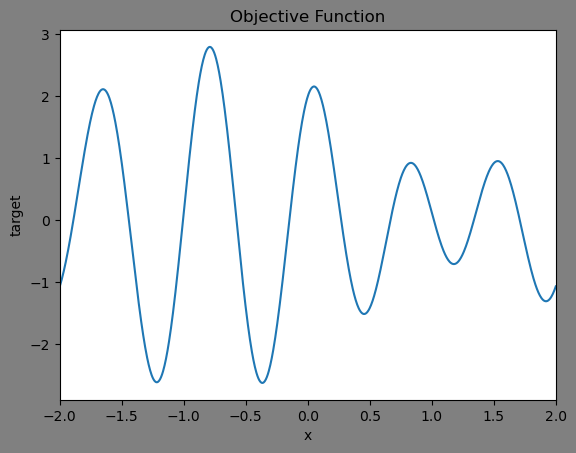

In [10]:
###################### Settings ############################################################################################################################
domain = 2 # defines lower and upper bound for parameter space (e.g. domain=2 means we plot the function in the intervall of (-2, 2) = (-domain, domain))
density = 1000 # defines the amount of parameters between -domain and -domain that are being used for this experiment

# The black box function can be adapted to any one-dimensional deterministic function
# Input: nx1 dimensional torch.Tensor
# Output: nx1 dimensional torch.Tensor
def black_box_function(X):
    return torch.sin(X * (2 * math.pi)) + torch.cos(X * (2 * math.pi + 1)) + torch.cos(X * (2 * math.pi + 2))

#############################################################################################################################################################

param_space = torch.linspace(-domain, domain, density, dtype=torch.double).reshape(-1, 1)
targets = black_box_function(param_space)

plt.figure(facecolor='grey')
plt.title("Objective Function")
plt.plot(param_space, targets)
plt.xlim([-domain, domain])
plt.xlabel("x")
plt.ylabel("target")
plt.show()

## Optimization Process

Now we can apply baysian optimization to find a good approximation to the optimal parameter values. Each iteration is plottet below to demonstrate the decision making of the process, which can again be adapted in the ###Settings### area.

The plot shows three functions plottet over the whole parameter-space: The objective function in the first row, the Gaussian process mean with 1.96 of its standard deviation in the second row as well as the acquisition function in the third row.

Two important parameters are __beta__ and __gamma__. Beta defines the trade off between taking the highest mean as an indication for a good candidate versus the highest variance. This can be translated into exploitation versus exploration. Since you usually want to start with more exploration to find good places in the parameter space and later with more exploitation to find an optimum in these places, __beta__ usually starts at a higher value (~5-30). Additionally, another parameter __gamma__ is introduced to lower __beta__ after each iteration. Varring both parameters can vastly influence the process behavior, so playing around with them is encouraged!

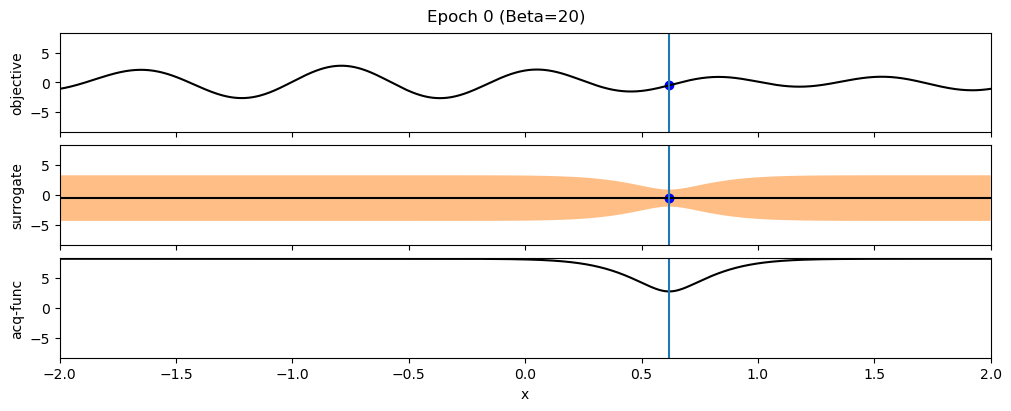

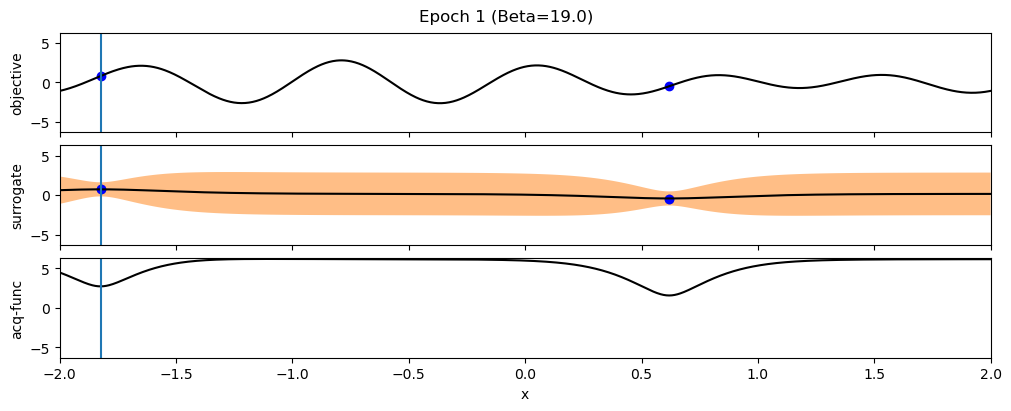

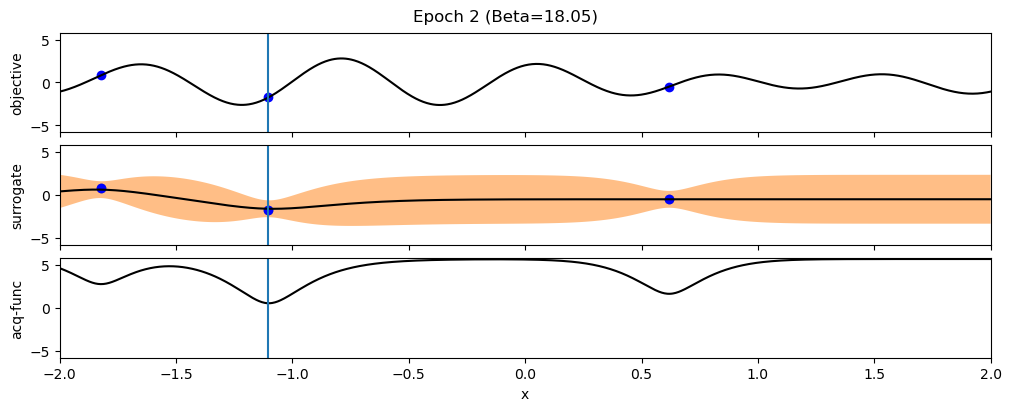

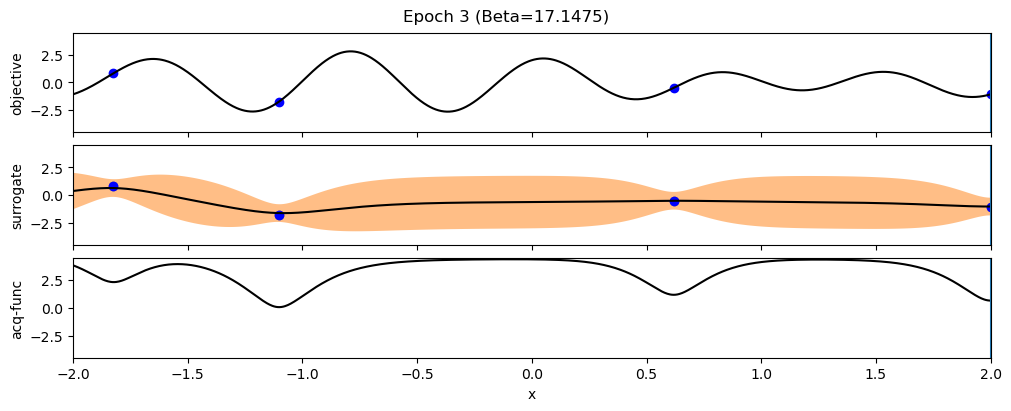

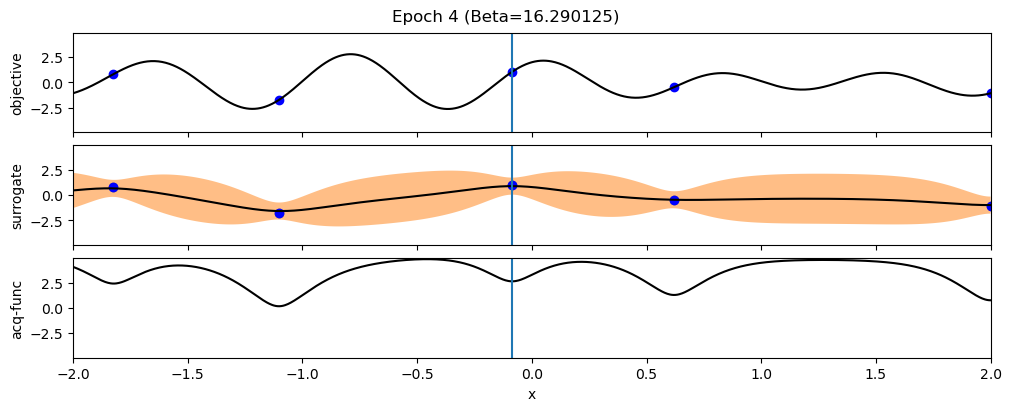

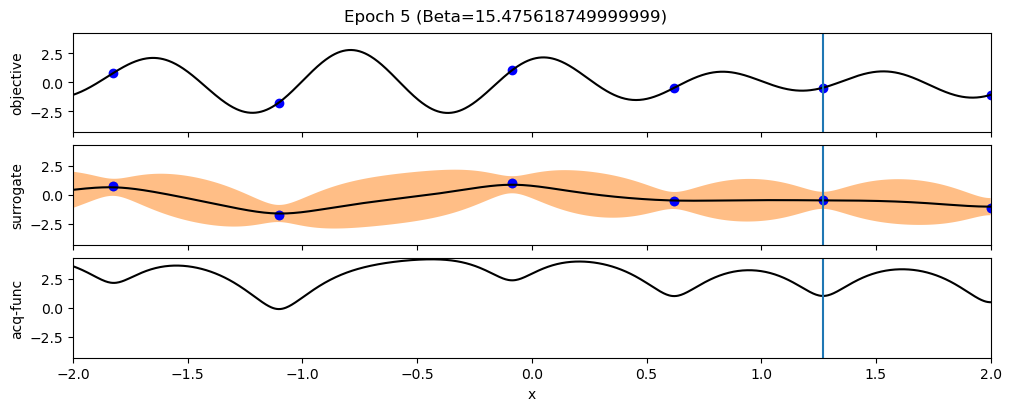

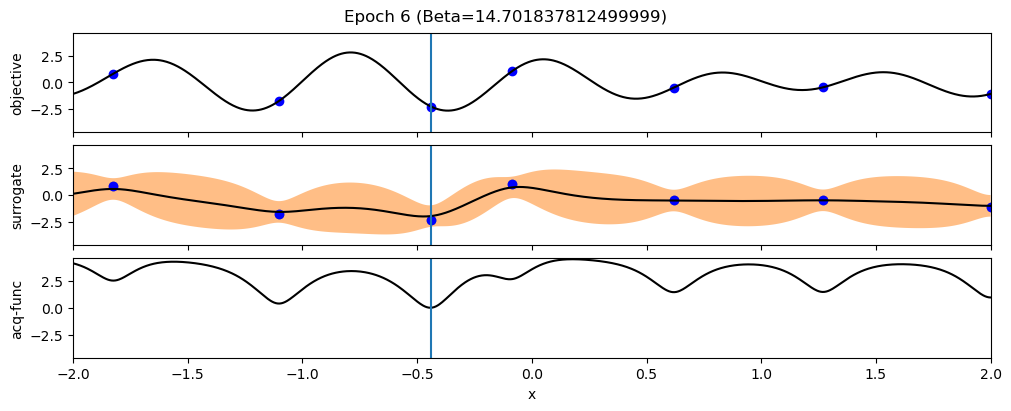

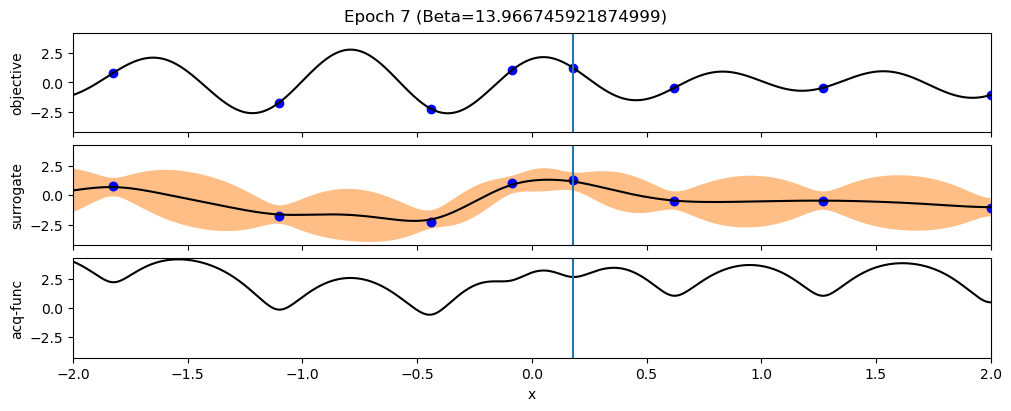

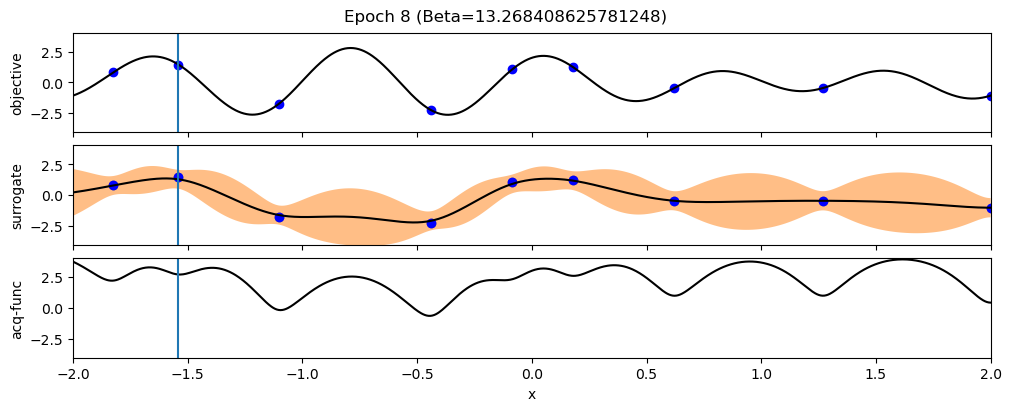

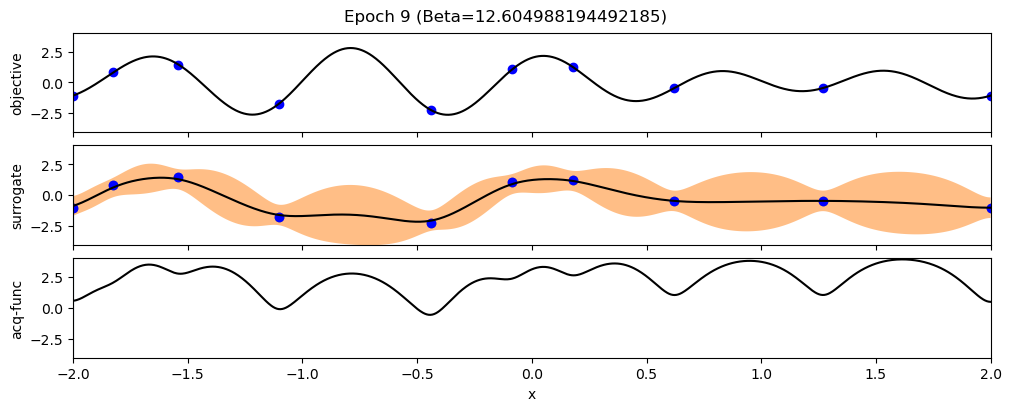

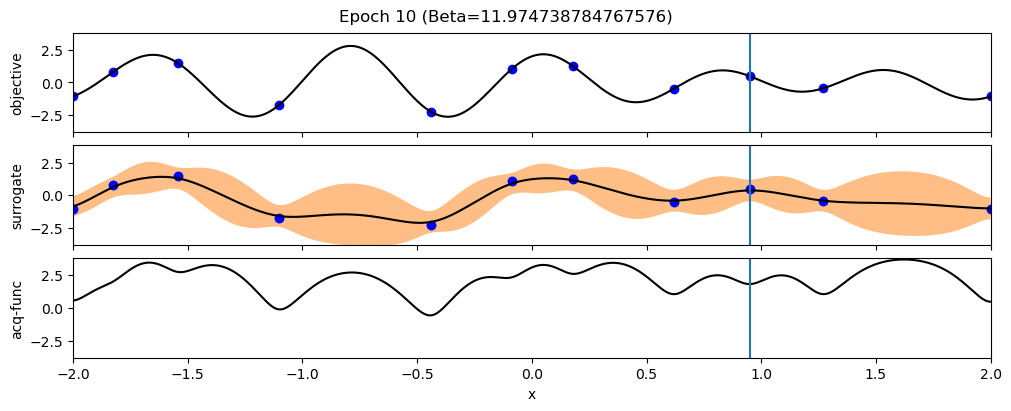

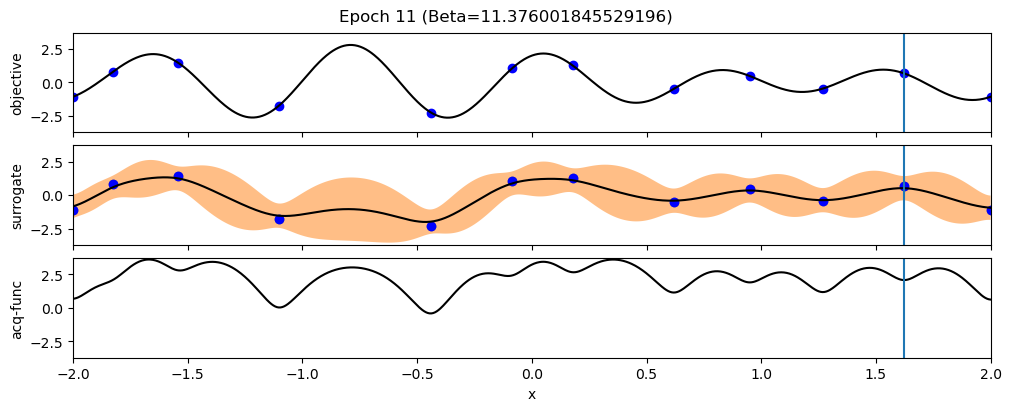

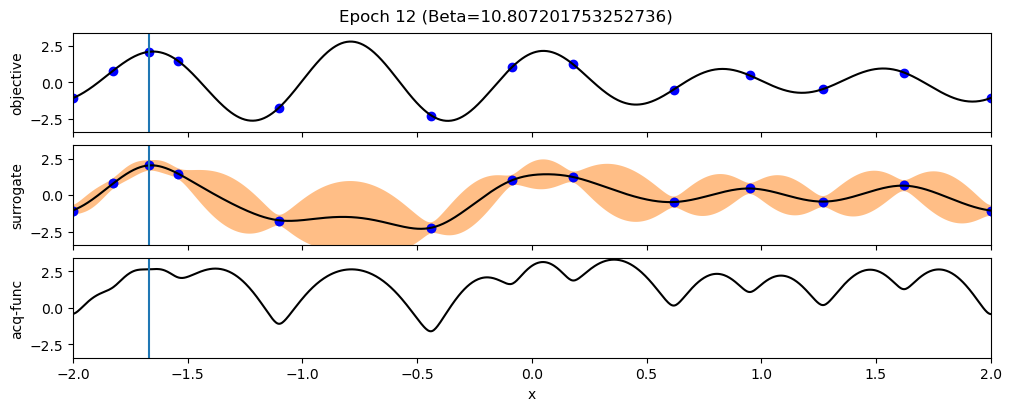

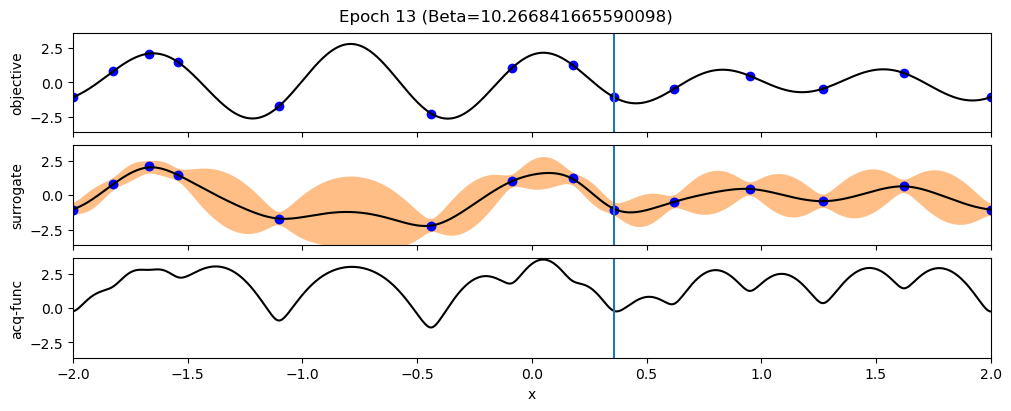

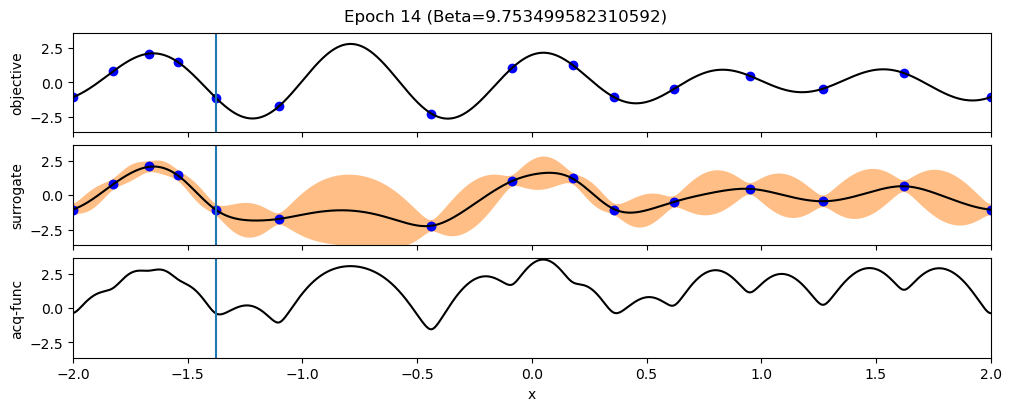

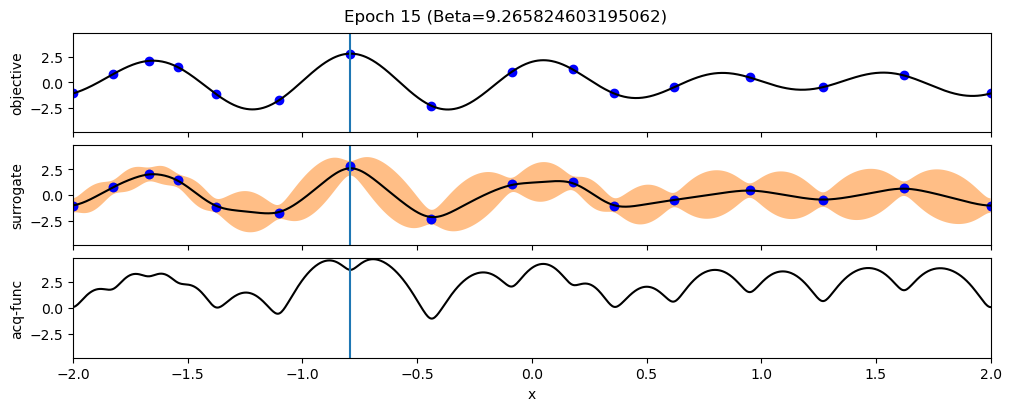

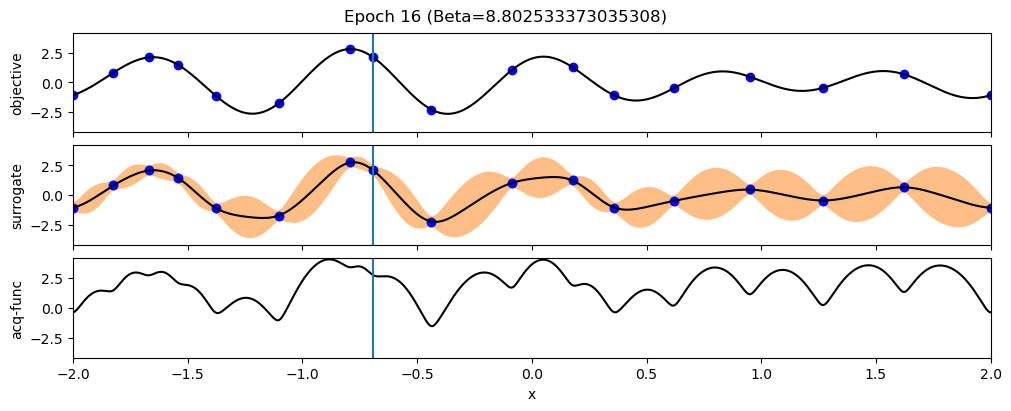

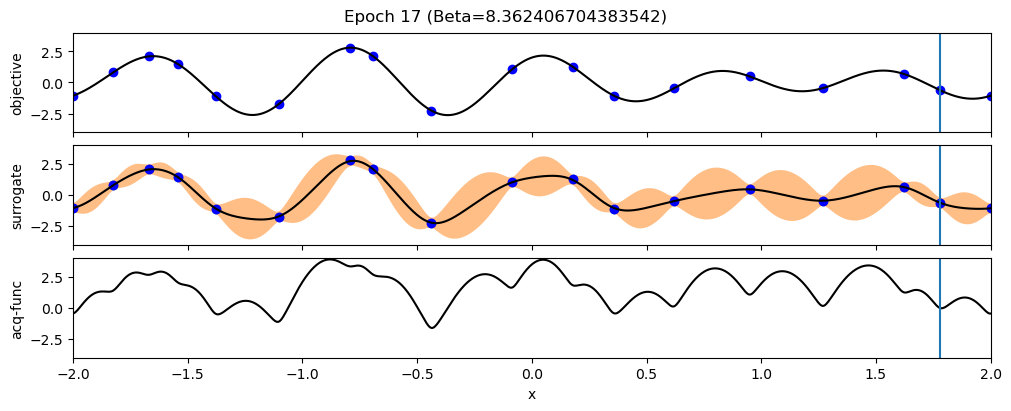

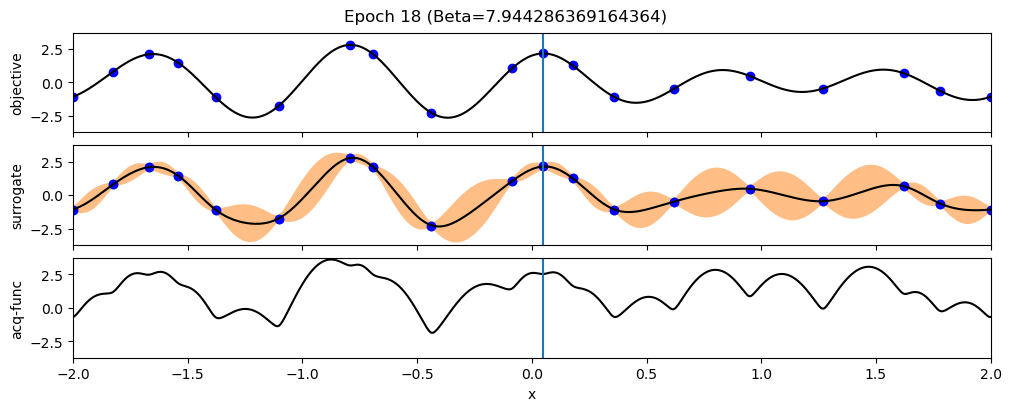

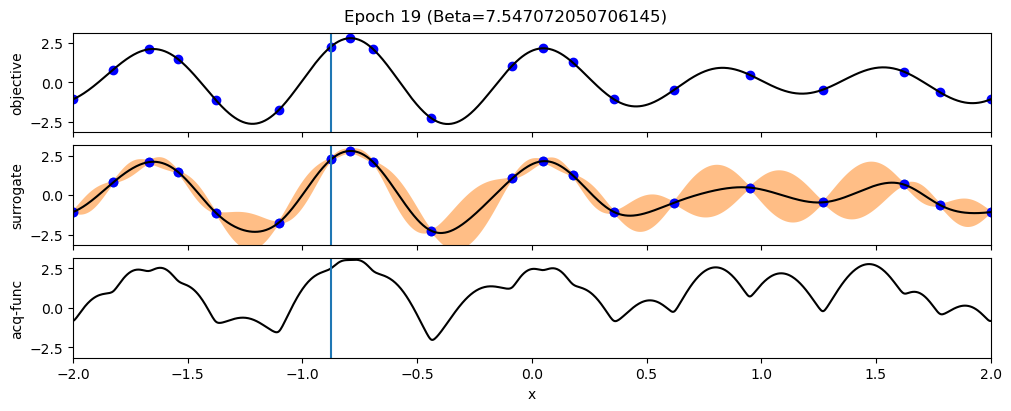

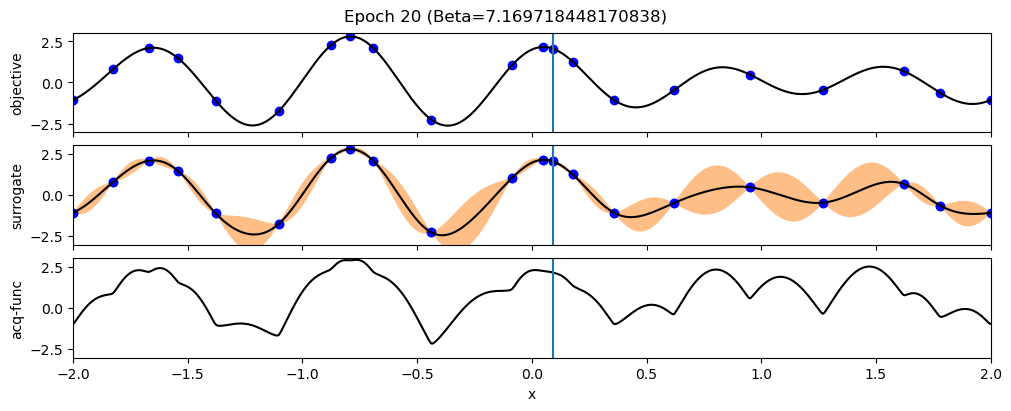

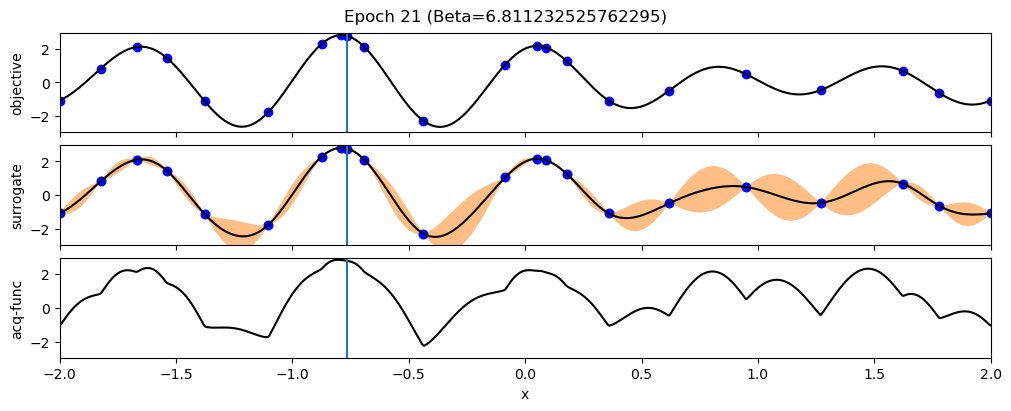

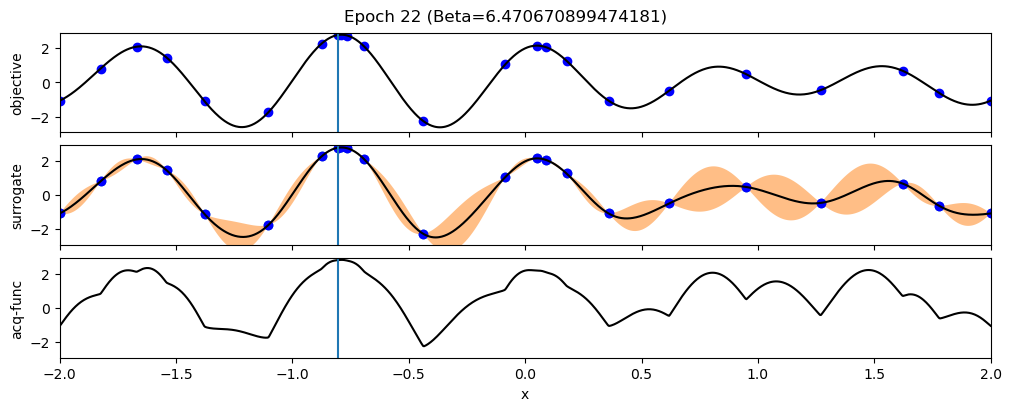

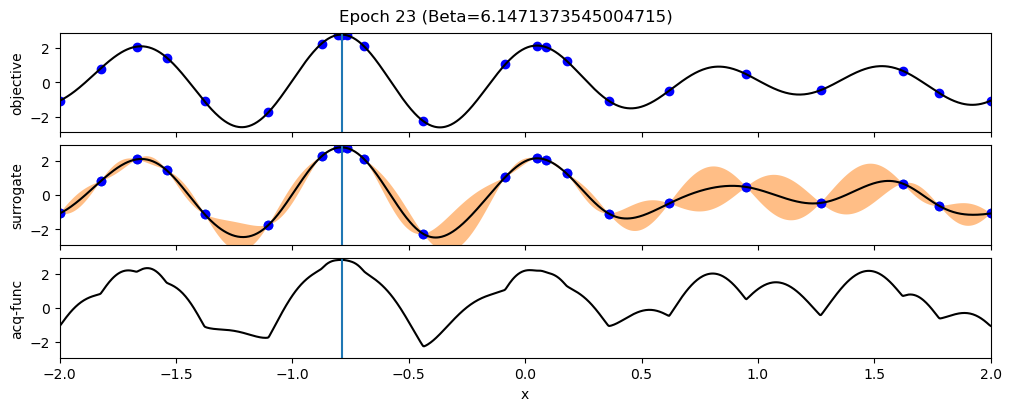

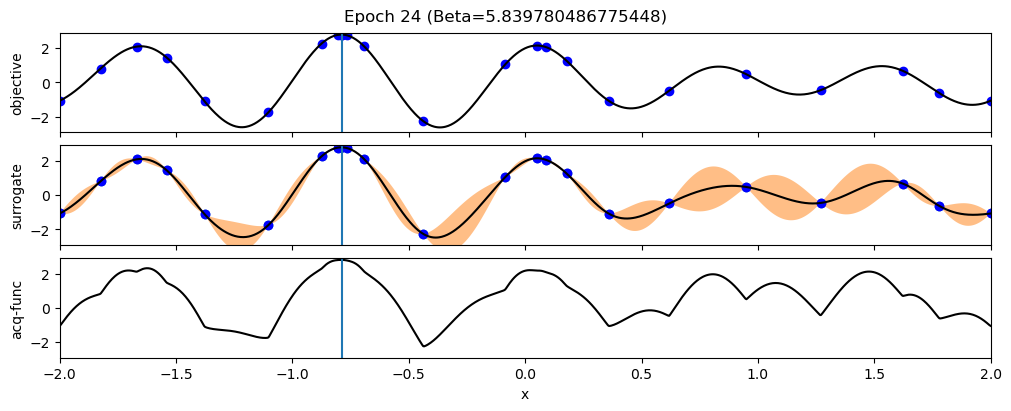

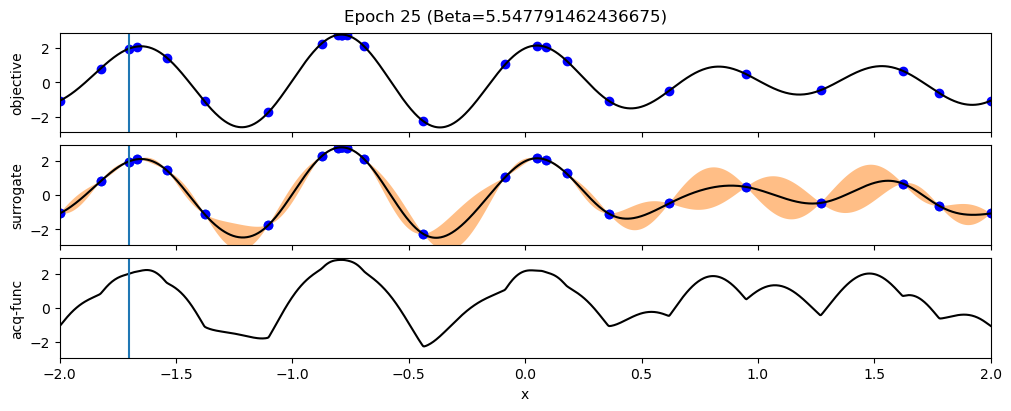

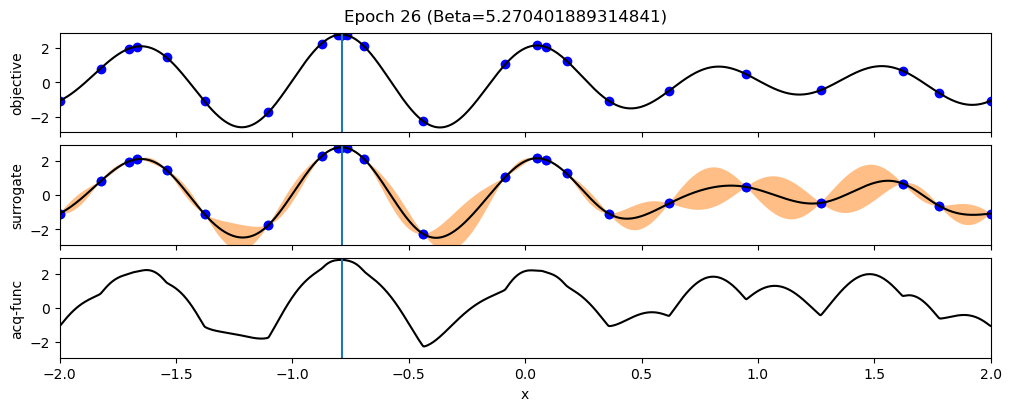

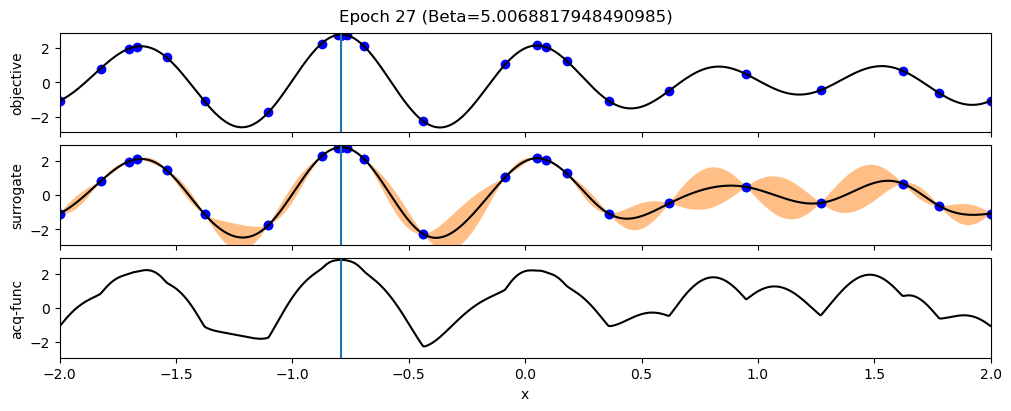

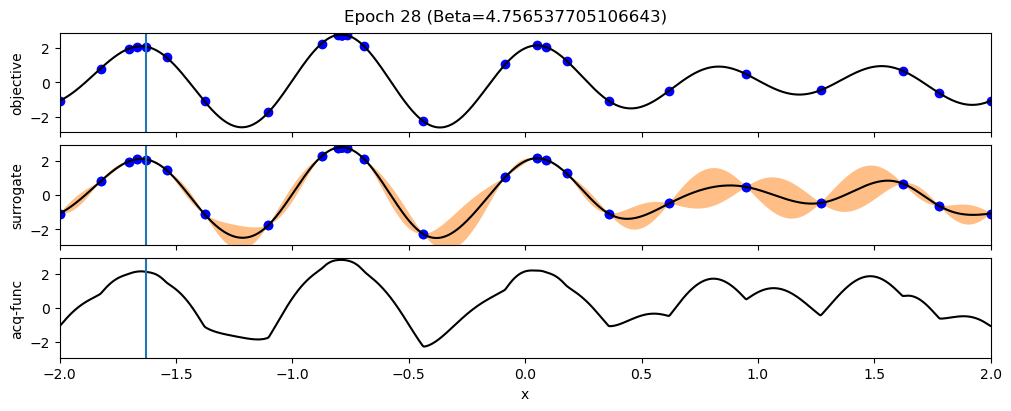

In [11]:
random.seed(42)
torch.manual_seed(42)
plot_assistant = PlotBO()

###################### Settings #######################################################################################

n_init = 1 # Initial points that are sampled randomly from the parameter space
n_iter = 29 # Number of Iterations that Bayesian Optimization is performed
eval_ratio = 1 # Each eval_ratio-iterations a plot of the current acq is shown
beta = 20 # Trade-off parameter between mean and covariance for ucb -> Higher = Exploration, Lower = Exploitation
gamma = 0.95 # Value between 0 and 1. Factor that continuesly reduces beta to change from exploration to exploitation

########################################################################################################################

# Sample n_init points as initial points
init_idx = random.sample(range(param_space.shape[0]), k=n_init)
x_train, y_train = param_space[init_idx], black_box_function(param_space[init_idx])

# Bayesian Optimization Loop
for i in range(n_iter):
    # Initialize likelihood and model and train model on train data
    model = SingleTaskGP(x_train, y_train)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll = fit_gpytorch_mll(mll)

    # Create an acquisition function and optimize it to find next best candidate
    acqf = UpperConfidenceBound(model, beta=beta)
    bounds = torch.stack([torch.ones(1)*-domain, torch.ones(1)*domain])
    candidate, acq_value = optimize_acqf(
        acqf, bounds=bounds, q=1, num_restarts=2, raw_samples=12,
    )

    if i%eval_ratio == 0 or i+1 == n_iter:
        plot_assistant.plot_bo_1d(param_space, domain, targets, x_train, y_train, model, acqf, i, beta)

    # Add next data point
    x_train = torch.cat((x_train, candidate))
    y_train = torch.cat((y_train, black_box_function(candidate)))

    # Update beta
    beta = gamma * beta


## 2 Dimensional Example

We repeat each step of the process shown for a two dimensional problem. Everything else stays (mostly) the same.

[]

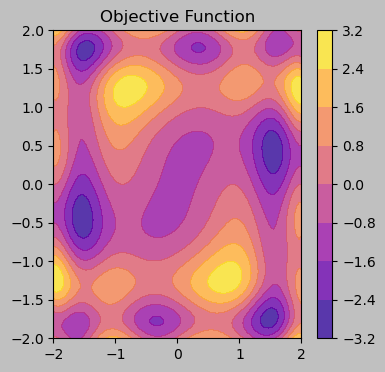

In [12]:
##################################### Settings #################################################
domain_2d = 2 # defines lower and upper bound for each parameter space defined by domain_2d
                # (e.g. domain_2d = 2 means we plot the function in the square space from (-2, -2) to (2, 2)
density_2d = 100 # Density per Parameter, so the total amount of samples is density_2d**2

# The black box function can be adapted to any one-dimensional deterministic function
# Input: nx2 dimensional torch.Tensor
# Output: nx1 dimensional torch.Tensor
def black_box_function_2d(X):
    return torch.sin(2*X[:,0]**2) - torch.cos(2*X[:,1]**2) - torch.sin(2*(X[:,0]*X[:,1]))
################################################################################################

xx, yy = torch.meshgrid(
    (
        torch.linspace(-domain_2d, domain_2d, density_2d, dtype=torch.double),
        torch.linspace(-domain_2d, domain_2d, density_2d,  dtype=torch.double)
    ),
    indexing='ij'
)
param_space_2d = torch.stack((xx.flatten(), yy.flatten()), dim=-1)
targets_2d = black_box_function_2d(param_space_2d)

plt.figure(figsize=(4,4), facecolor='silver')
plt.title("Objective Function")
plt.contourf(xx, yy, targets_2d.view(xx.shape), alpha=.8, zorder=-1, cmap='plasma')
plt.colorbar()
plt.plot()

## 2 Dimensional Optimization Process

Now that we've found an interestingly looking function, we would like to apply bayesian optimization to it!

Plots now contain 4 Subplots over the whole (2-dimensional) parameter-space: The objective function (top-left), the variance of the Gaussian Process (top-right), the mean of the gaussian process (lower-right) and the acquisition function (lower-left).

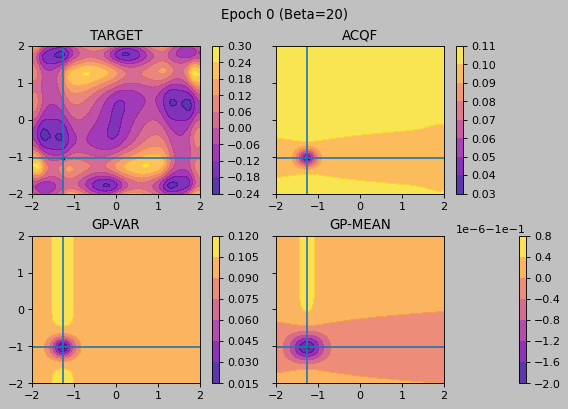

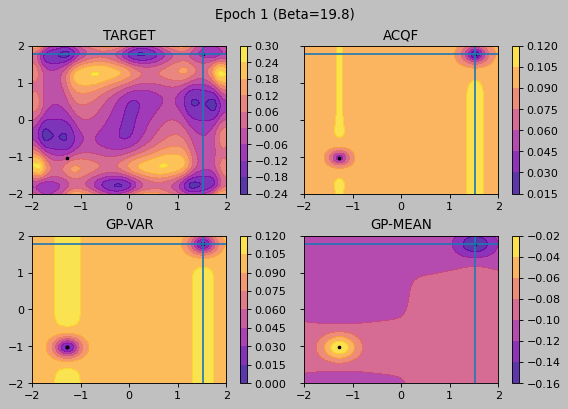

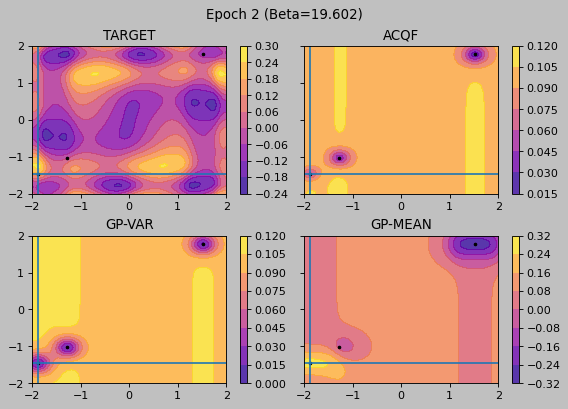

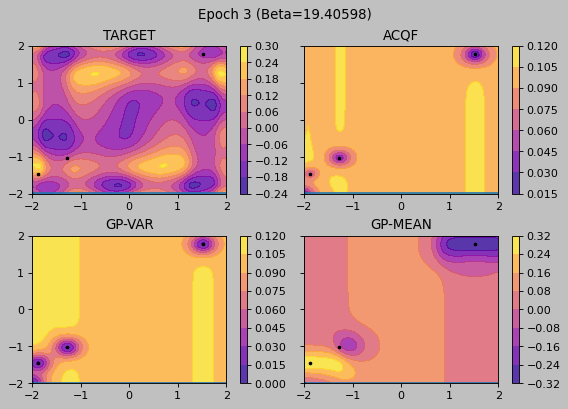

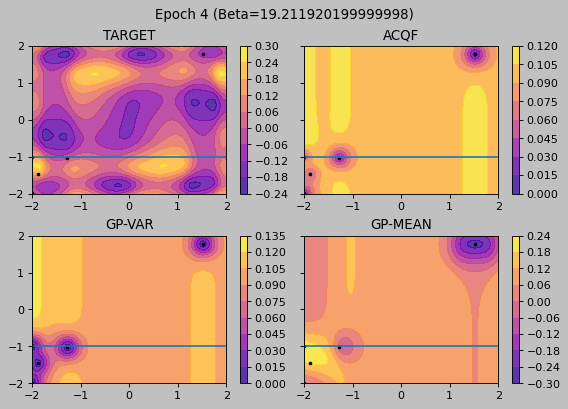

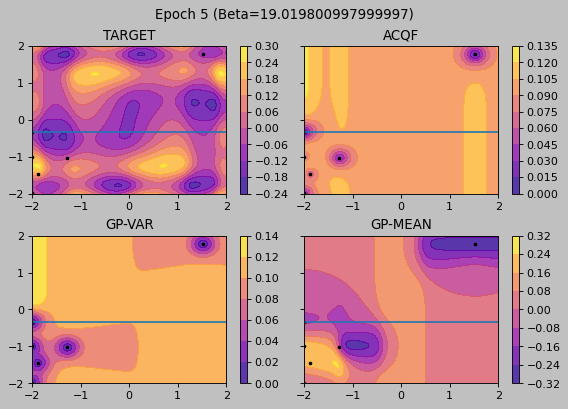

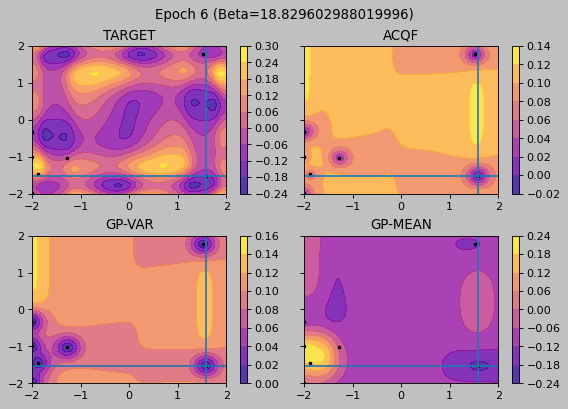

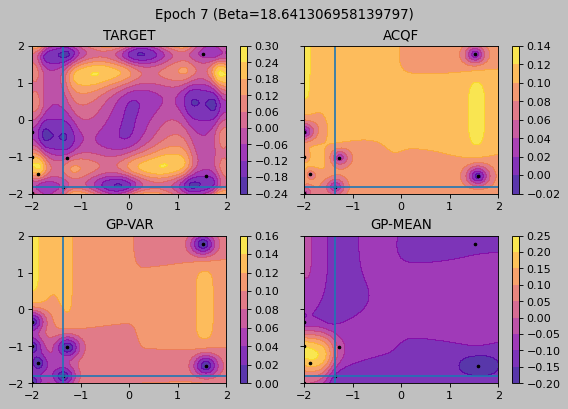

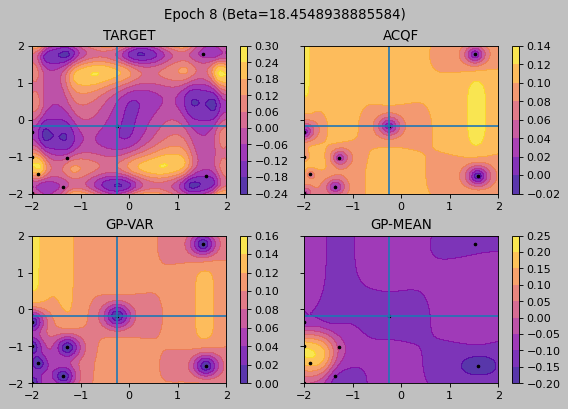

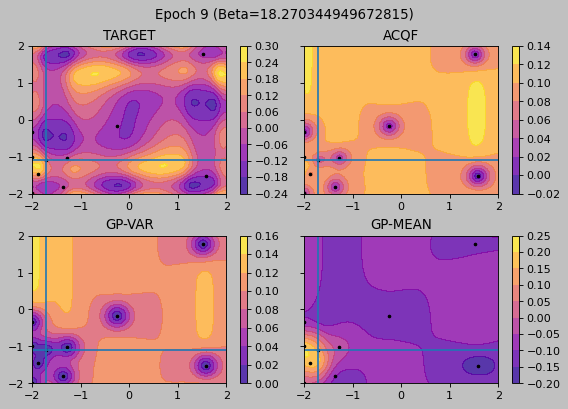

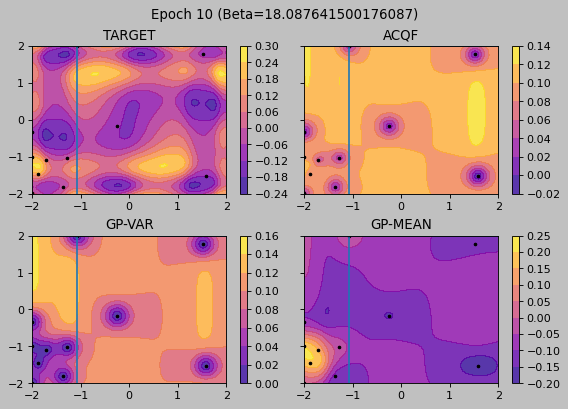

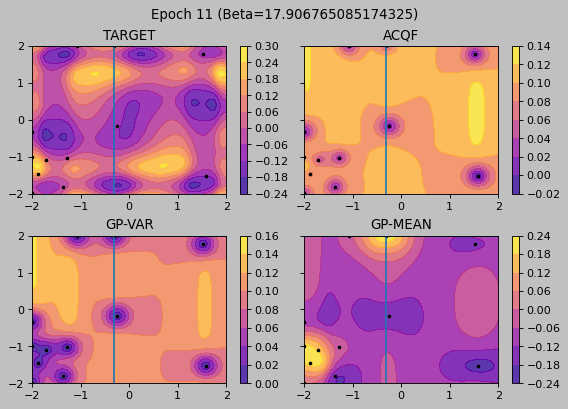

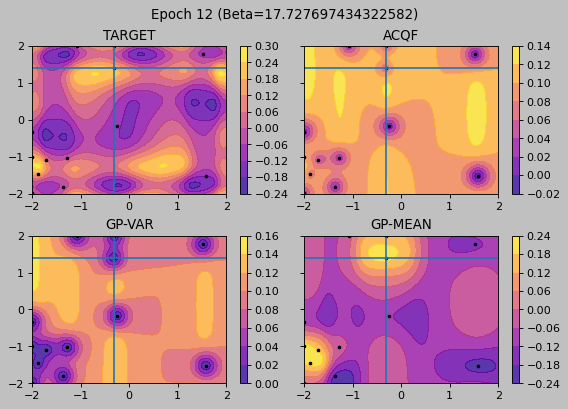

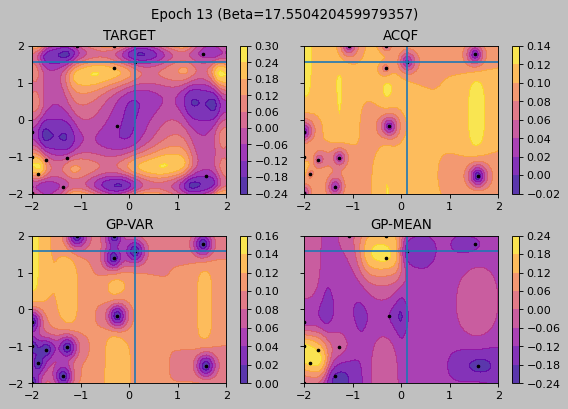

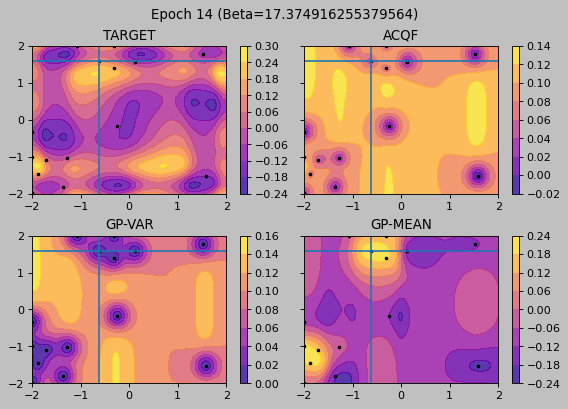

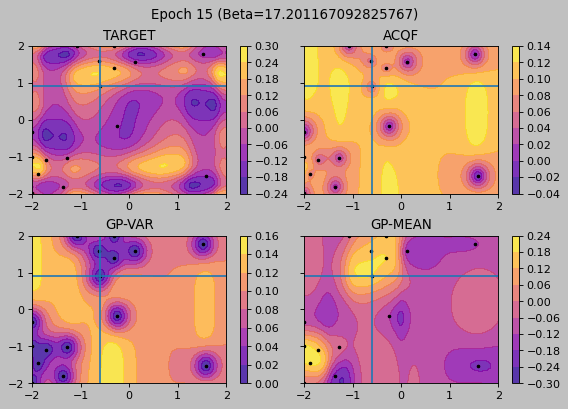

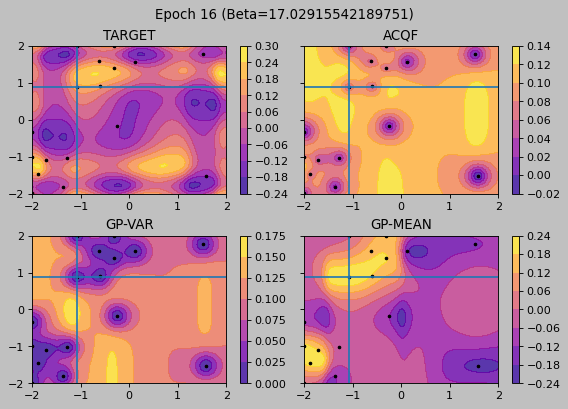

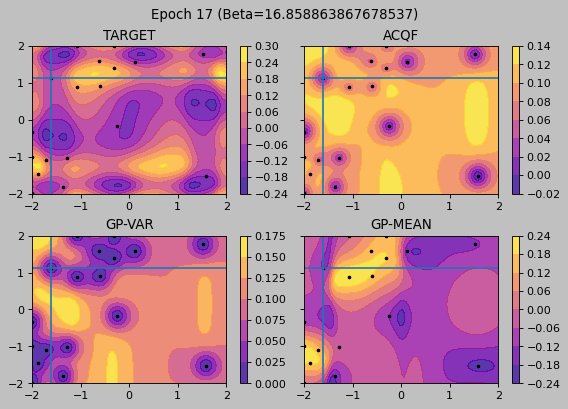

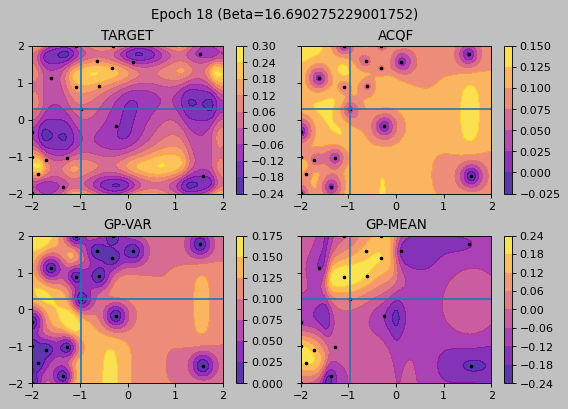

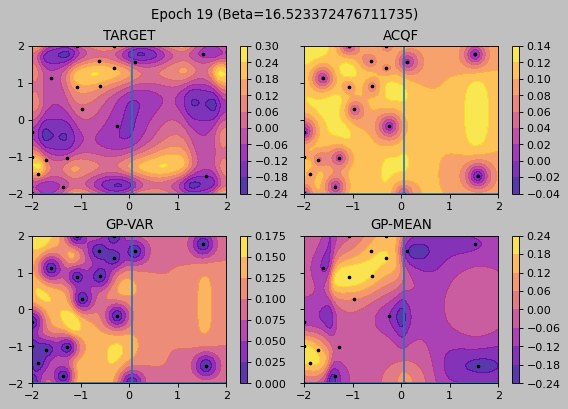

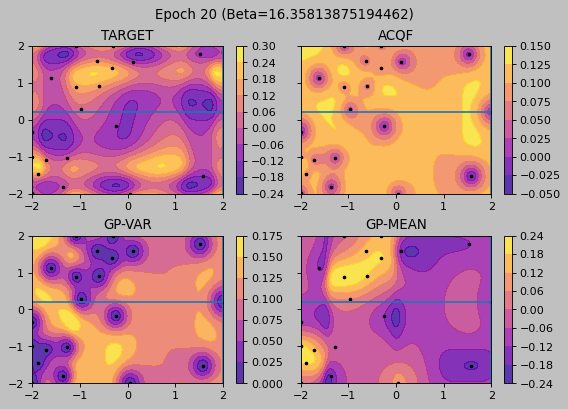

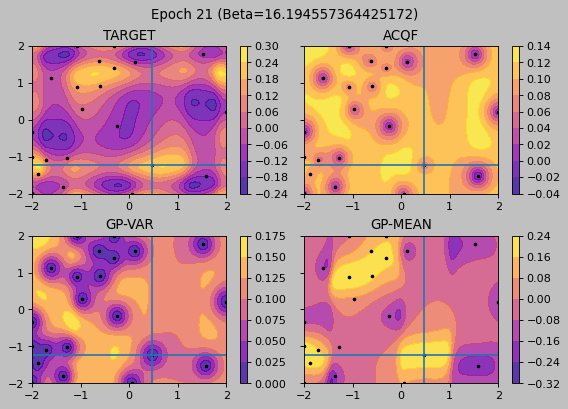

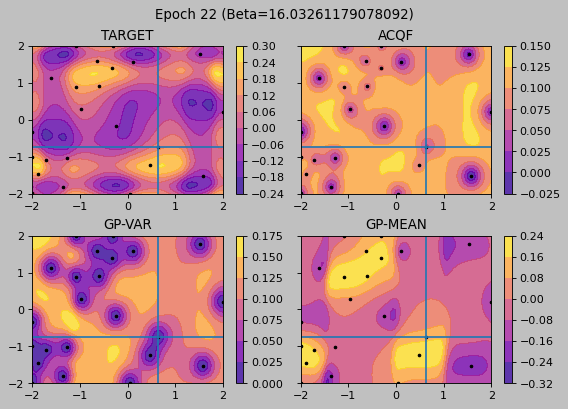

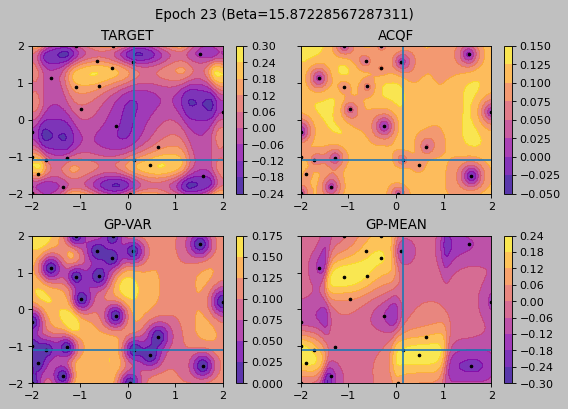

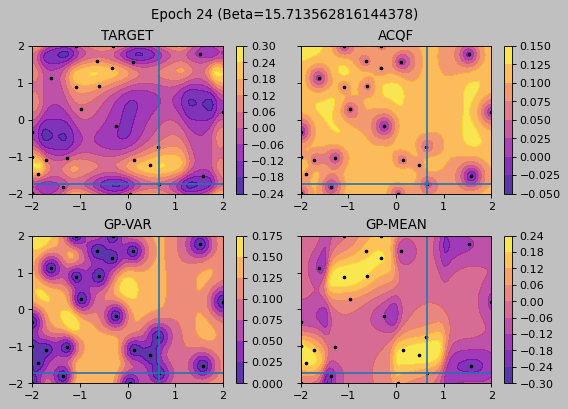

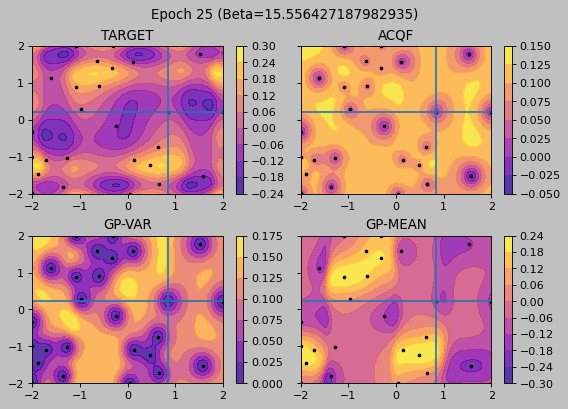

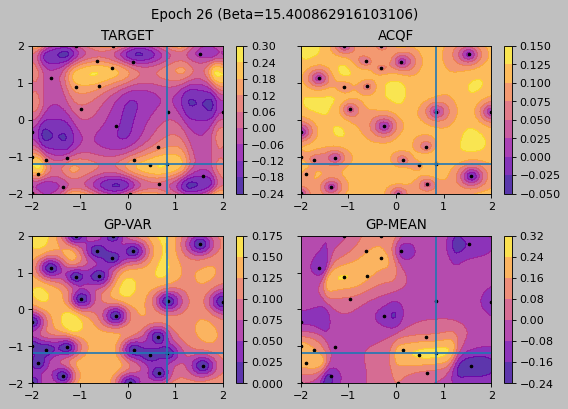

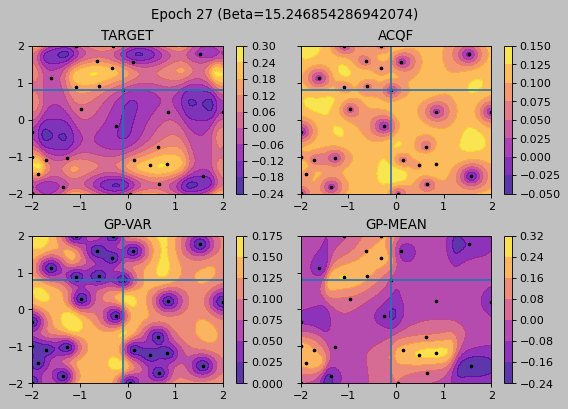

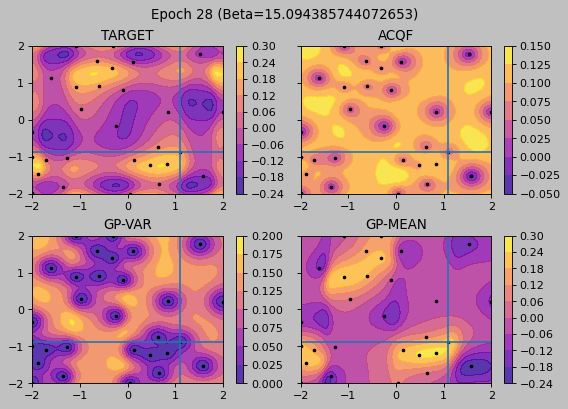

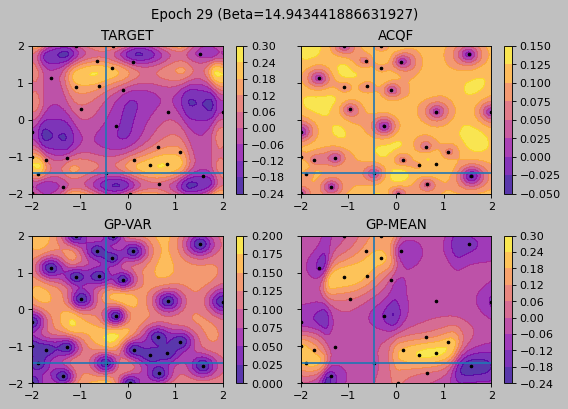

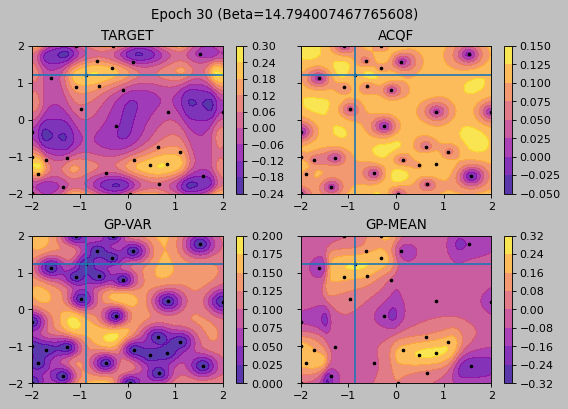

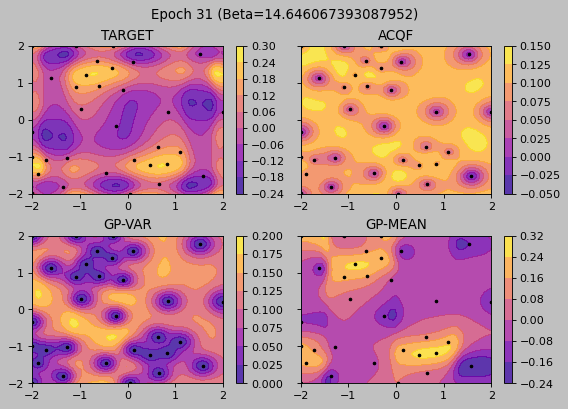

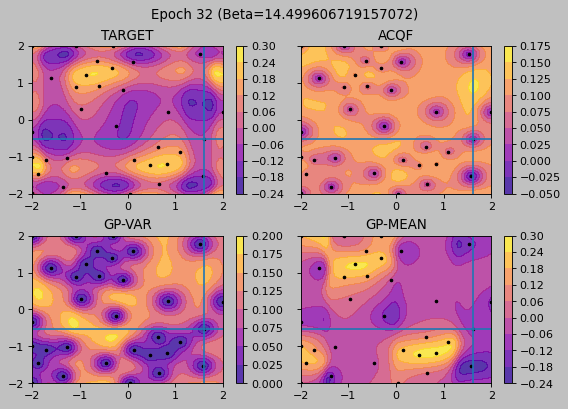

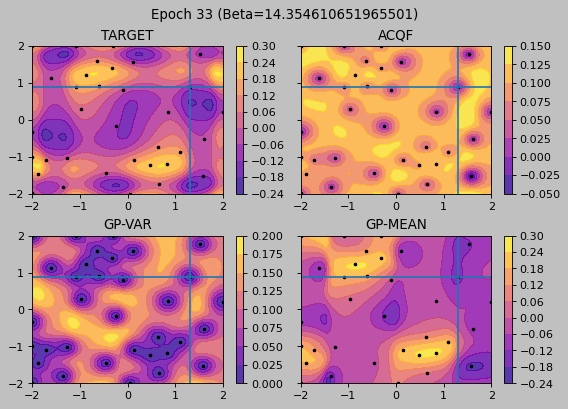

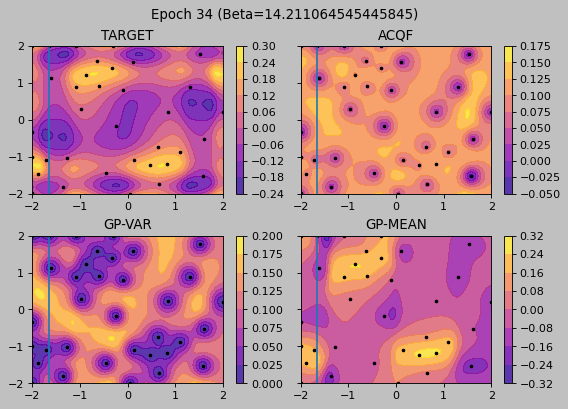

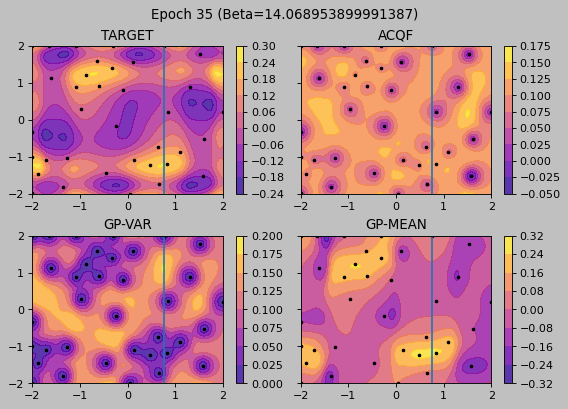

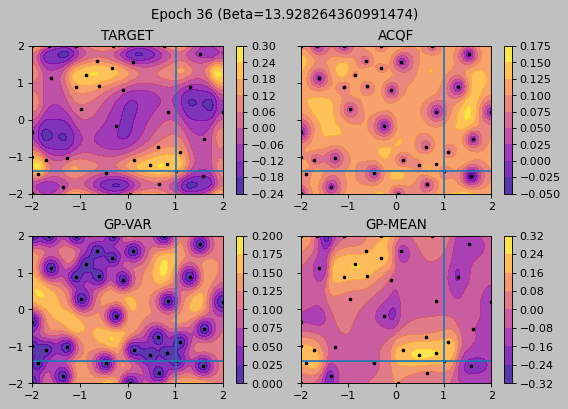

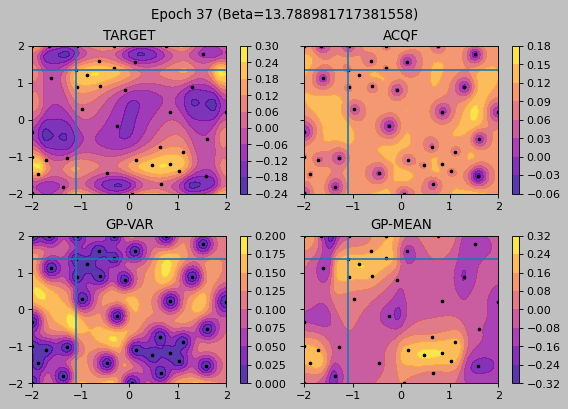

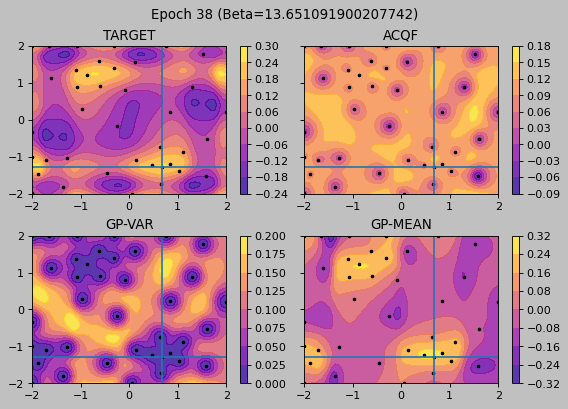

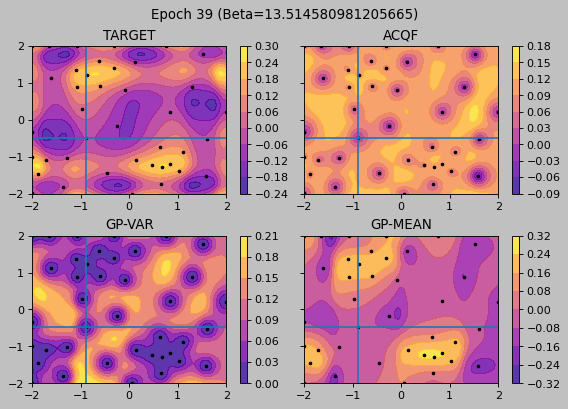

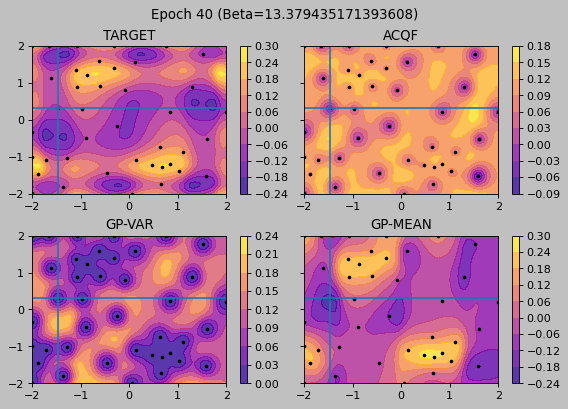

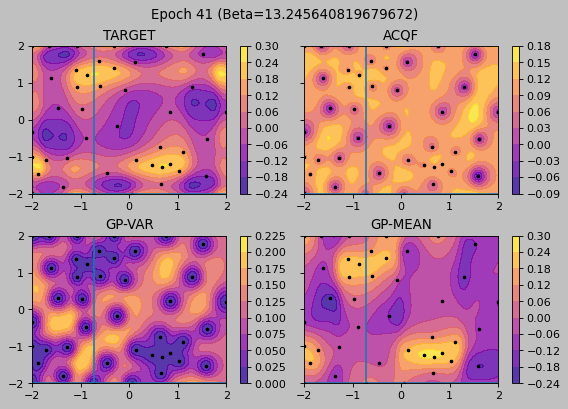

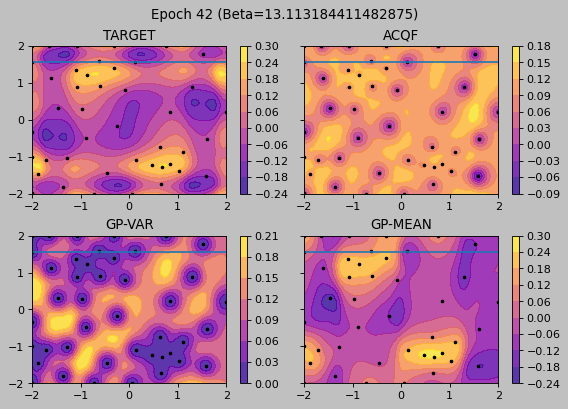

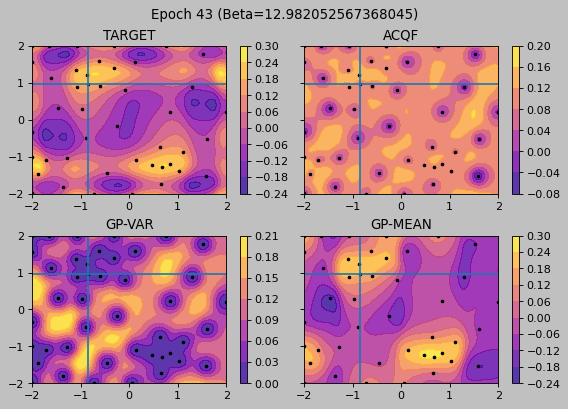

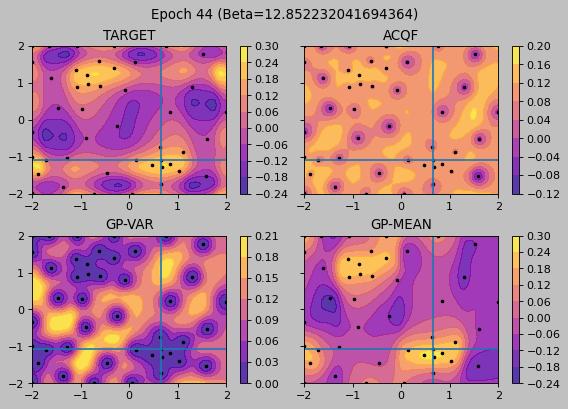

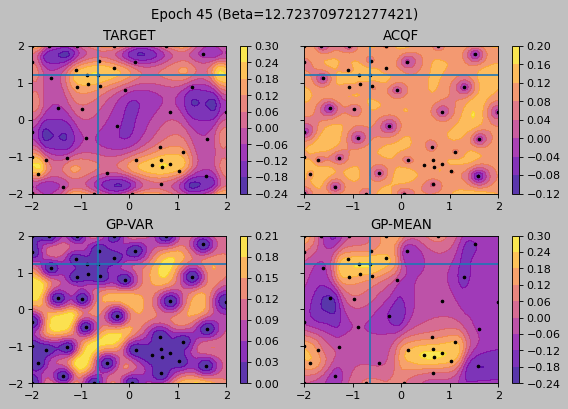

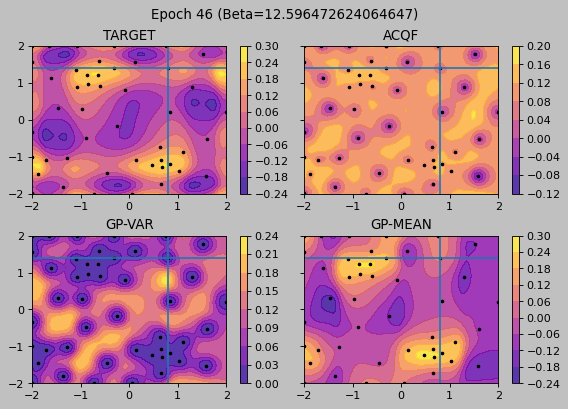

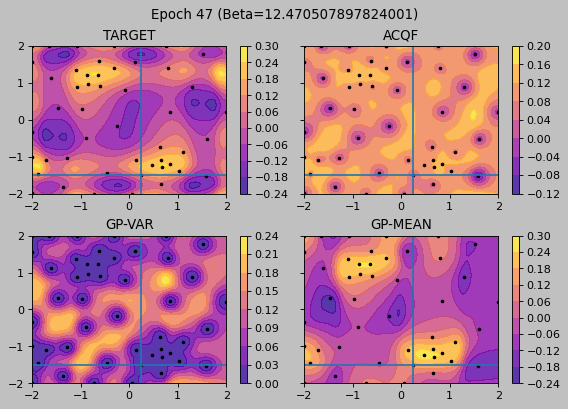

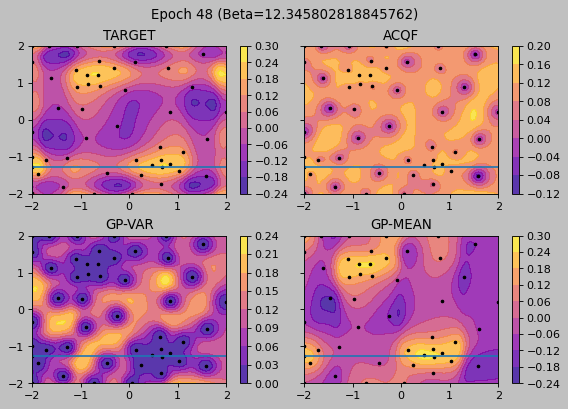

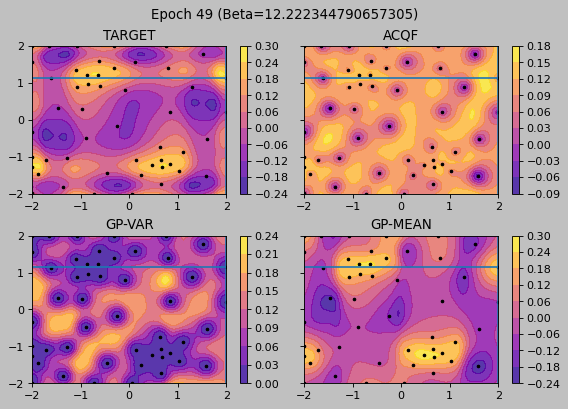

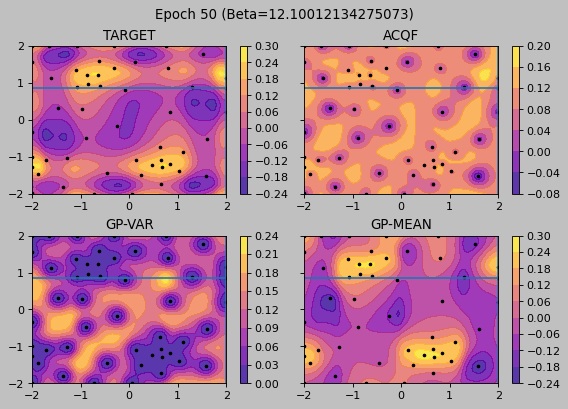

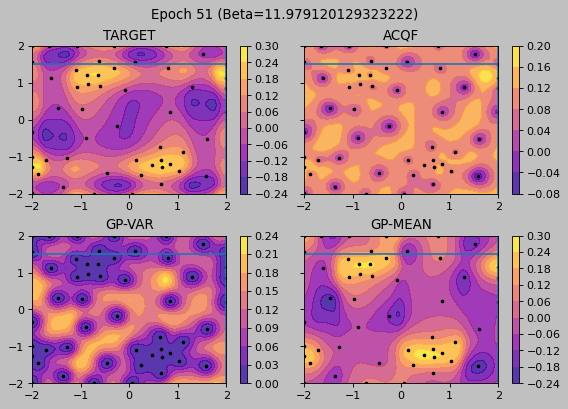

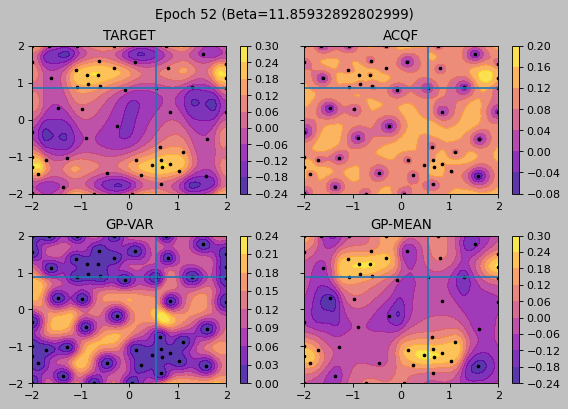

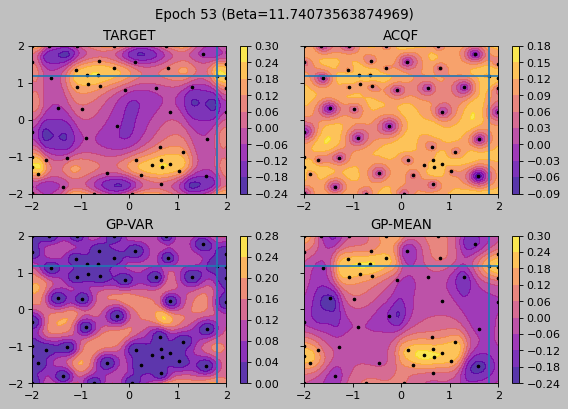

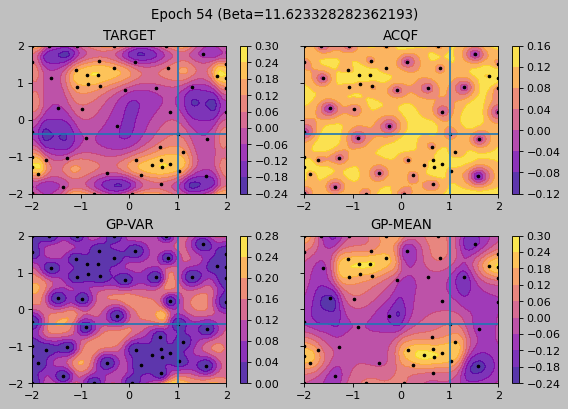

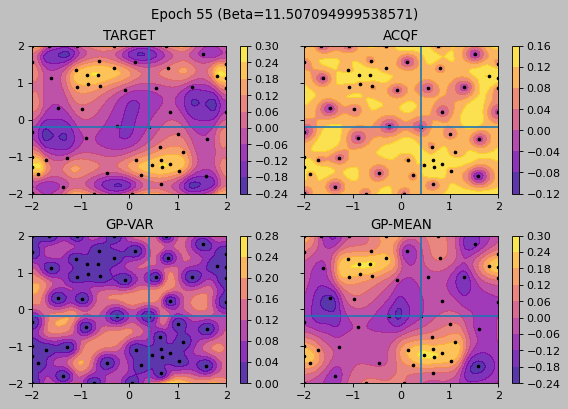

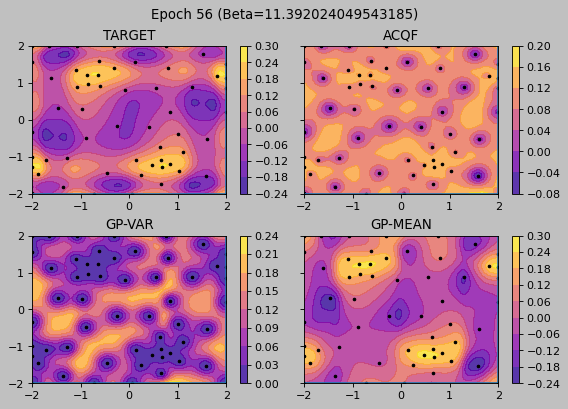

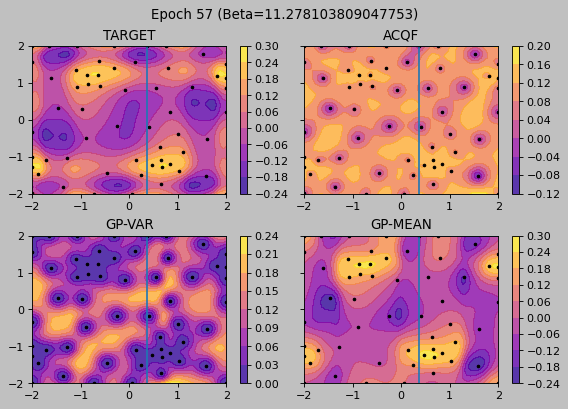

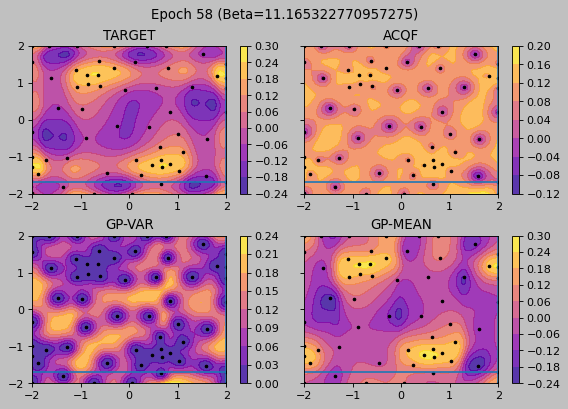

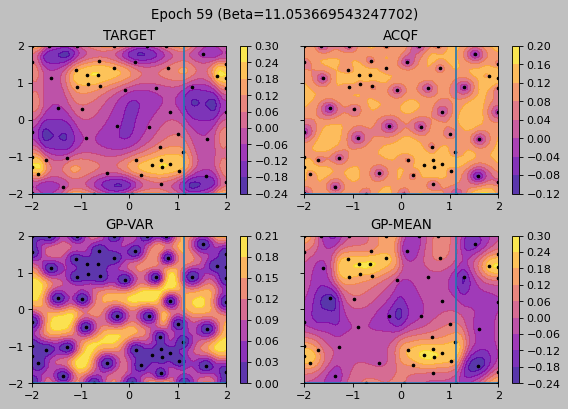

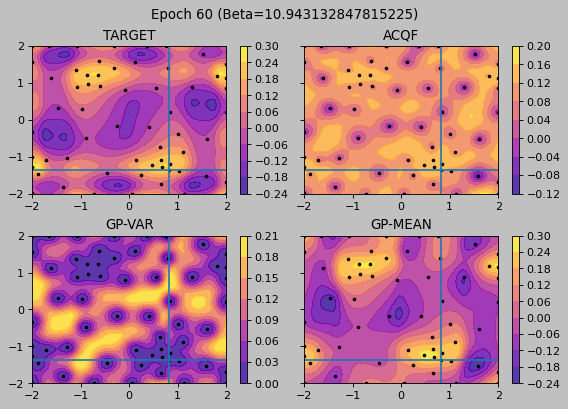

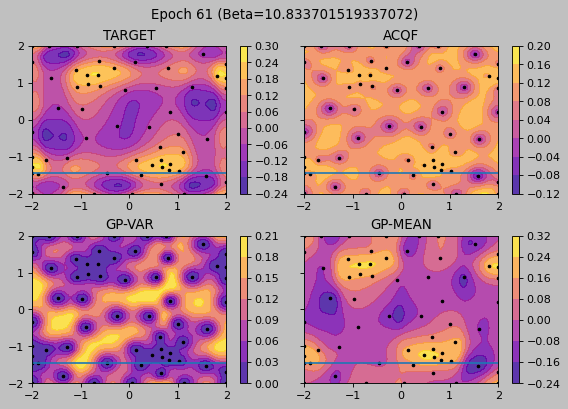

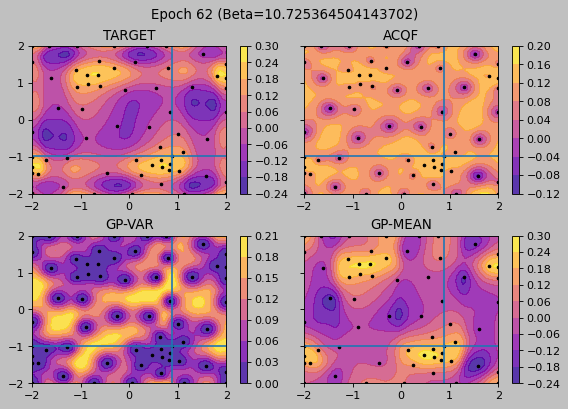

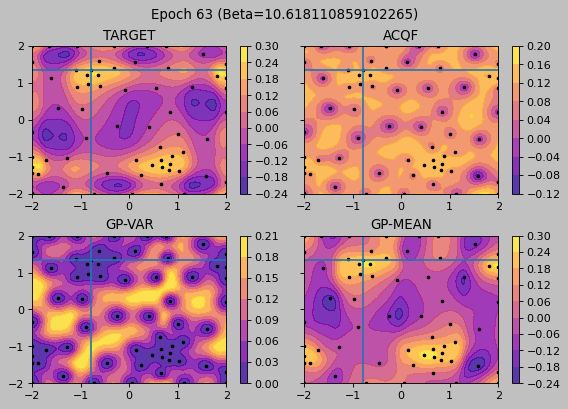

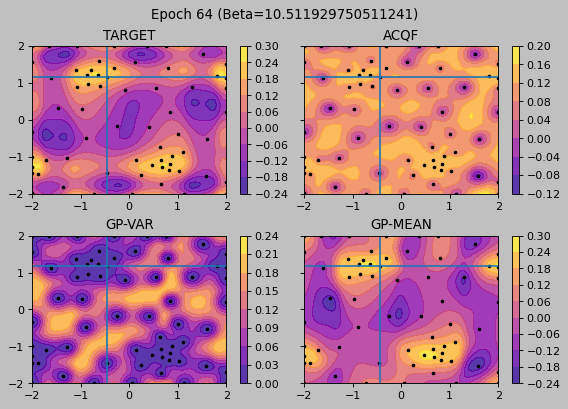

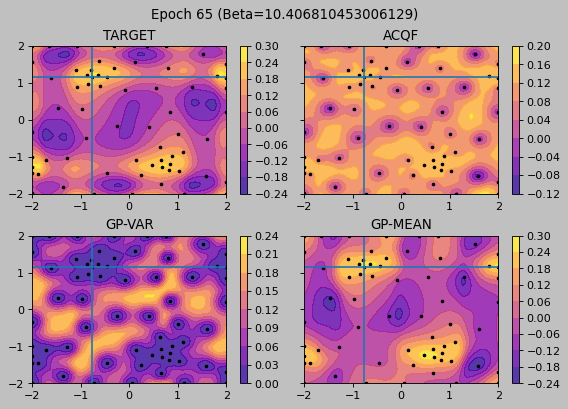

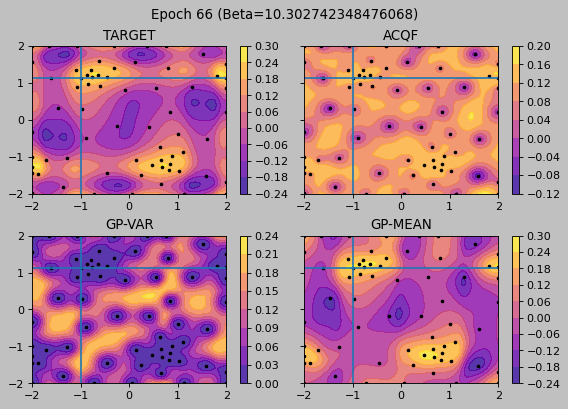

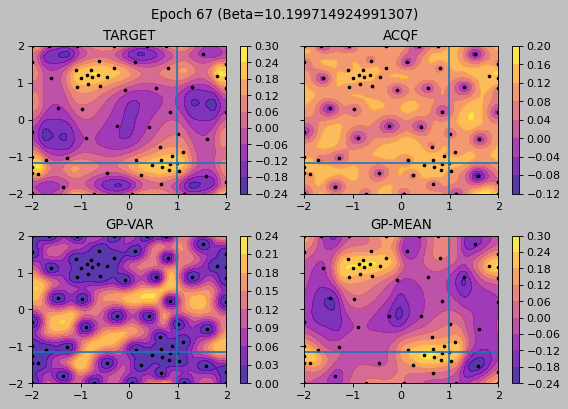

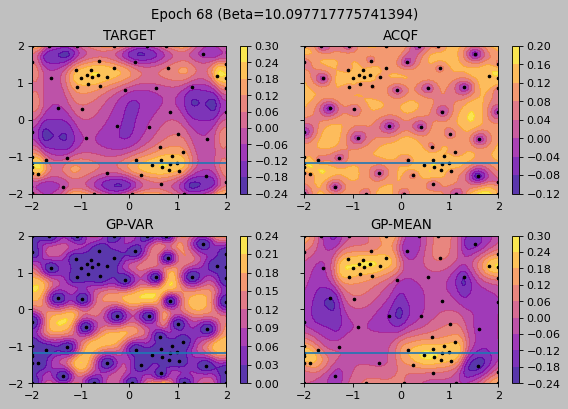

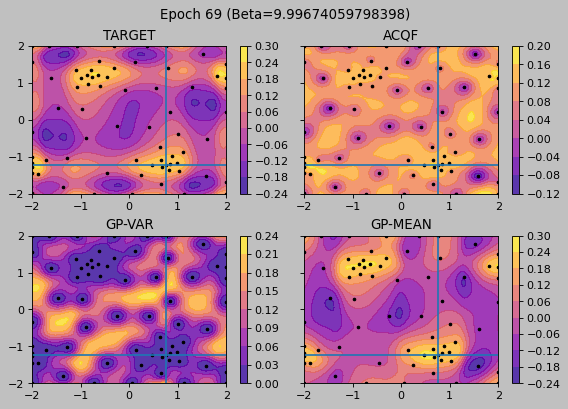

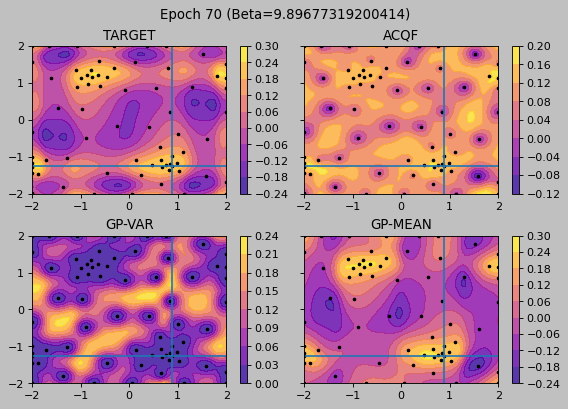

In [19]:
random.seed(42)
torch.manual_seed(42)
plot_assistant = PlotBO()

################################ Settings #####################################################

n_init = 1 # Initial Points that are sampled randomly from the parameter space
n_iter = 71 # Number of Iterations we should perform Bayesian Optimization
eval_ratio = 1 # Each eval_ratio-iterations a plot of the current acq is shown
beta = 20 # positive Value. Trade-off parameter between mean and covariance for ucb -> Higher = Exploration, Lower=Exploitation
gamma = 0.99 # Value between 0 and 1. Factor that continuesly reduces beta to change from exploration to exploitation

########################################################################################################################

# Sample n_init points as initial points
init_idx = random.sample(range(param_space_2d.shape[0]), k=n_init)
x_train, y_train = param_space_2d[init_idx], black_box_function_2d(param_space_2d[init_idx]).reshape(-1, 1)

# Bayesian Optimization Loop
for i in range(n_iter):
    # Initialize likelihood and model and train model on train data
    model = SingleTaskGP(x_train, y_train)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll = fit_gpytorch_mll(mll)

    # Create an acquisition function and optimize it to find next best candidate
    acqf = UpperConfidenceBound(model, beta=beta)
    bounds = torch.stack([torch.ones(2)*-domain_2d, torch.ones(2)*domain_2d])
    candidate, acq_value = optimize_acqf(
        acqf, bounds=bounds, q=1, num_restarts=5, raw_samples=50,
    )

    # Plotting Results each eval_ratio-steps
    if i%eval_ratio == 0:
        plot_assistant.plot_bo_2d(domain_2d, xx, yy, param_space_2d, targets_2d, acqf, model, x_train, i, beta)

    # Evaluate this candidate by running it through the actual objective function
    bbf_value = black_box_function_2d(candidate).reshape(-1, 1)

    # Add data point to the training samples and repeat
    x_train = torch.cat((x_train, candidate), dim=0)
    y_train = torch.cat((y_train, bbf_value), dim=0)

    # Update beta value
    beta = beta * gamma